In [48]:
from monai.transforms import (
    LoadImaged,
    Compose,
    RandRotate90d,
    ScaleIntensityd,
    Resized,
)
from monai.data import PILReader
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import torch
import monai

# more images is definitely better, but the training time is larger...
imgs = sorted(glob(os.path.join("data", "imgs", "*.png")))[:3000]
masks = sorted(glob(os.path.join("data", "masks", "*.png")))[:3000]

n = len(imgs)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

print(f"Number of images: {n}")

train_size = int(TRAIN_RATIO * n)
val_size = int(VAL_RATIO * n)
test_size = n - train_size - val_size
train_size += n - (train_size + val_size + test_size)

files = [{"img": img, "mask": mask} for img, mask in zip(imgs, masks)]

train_files, val_files, test_files = torch.utils.data.random_split(
    files,
    [train_size, val_size, test_size],
)

train_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        RandRotate90d(keys=["img", "mask"], prob=0.5, spatial_axes=(0, 1)),
        Resized(keys=["img", "mask"], spatial_size=(256, 256)),
    ]
)

val_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        Resized(keys=["img", "mask"], spatial_size=(256, 256)),
    ]
)

train_dataset = monai.data.Dataset(data=train_files, transform=train_transform)
val_dataset = monai.data.Dataset(data=val_files, transform=val_transform)
test_dataset = monai.data.Dataset(data=test_files, transform=val_transform)

Number of images: 3000


In [49]:
import torch
import gc
from tqdm import trange

from monai.networks.nets import UNet
from monai.losses import DiceLoss
import matplotlib.pyplot as plt
import monai
from pathlib import Path

# from resunet2 import UNet
from resunet import ResUNet

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

torch.backends.cudnn.benchmark = True

plt.set_cmap("gray")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
lr = 0.001
nepochs = 400
bs = 32

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(sigmoid=True)

train_dataloader = monai.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=8
)
val_dataloader = monai.data.DataLoader(
    val_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)
test_dataloader = monai.data.DataLoader(
    test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)

train_losses = []
val_losses = []
val_interval = 2
save_interval = 10
save_dir = "model"
Path(save_dir).mkdir(exist_ok=True)

for epoch in (pbar := trange(nepochs)):
    model.train()
    train_loss = 0.0
    for i, batch_data in enumerate(train_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        optimizer.zero_grad(set_to_none=True)
        output = model(img)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        train_loss += curr_loss
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(train_dataloader)}, loss: {curr_loss}"
        )
    train_losses.append(train_loss / len(train_dataloader))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i, batch_data in enumerate(val_dataloader):
                img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
                output = model(img)
                loss = criterion(output, mask)
                curr_loss = loss.item()
                val_loss += curr_loss
                pbar.set_description(
                    
                    f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(val_dataloader)}, loss: {curr_loss}"
                )
            val_loss_mean = val_loss / len(val_dataloader)
            val_losses.append(val_loss_mean)

    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_{epoch+1}.pth"))

cuda:0


Epoch 5/400, iteration 1/66, loss: 0.9985268115997314:   1%|▏         | 5/400 [00:19<25:37,  3.89s/it] 


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.title("Train loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("train_loss.png")
plt.show()
plt.plot(val_losses, label="val", color="orange")
plt.title("Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("val_loss.png")
plt.show()

In [ ]:
filename = "./model-monai-400epoch-3000img-256x256v2.pth"
torch.save(model.state_dict(), filename)

In [3]:
import torch
from monai.networks.nets import UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# filename = "./models/best-model/model-monai-400epoch-3000img-256x256.pth"
filename = "./model-monai-400epoch-3000img-256x256v2.pth"

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(filename))

<All keys matched successfully>

Average iou: 0.65
Average dice coefficient: 0.75
Average recall: 0.69
Average precision: 0.85


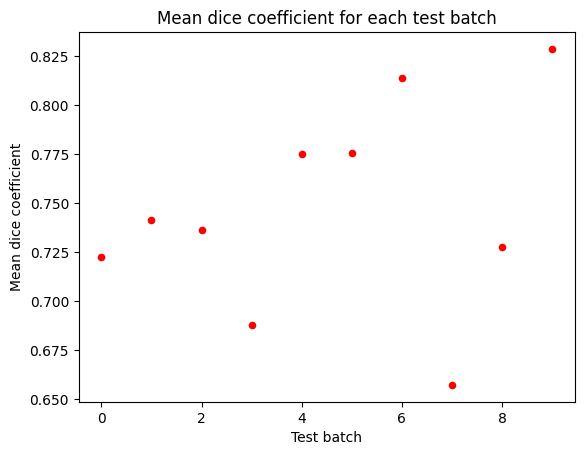

In [10]:
from monai.metrics import compute_iou, compute_dice

from util import recall, precision

dices = []
ious = []
recalls = []
precisions = []

model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        output = torch.sigmoid(model(img))
        torch.where(
            output > 0.5,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=output,
        )
        torch.where(
            mask > 0.0,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=mask,
        )
        dice_coeff = compute_dice(output, mask, ignore_empty=False).mean(dim=0)
        iou = compute_iou(output, mask, ignore_empty=False).mean(dim=0)
        r = recall(mask, output).mean()
        p = precision(mask, output).mean()
        dices.append(dice_coeff.item())
        ious.append(iou.item())
        recalls.append(r.item())
        precisions.append(p.item())
print(f"Average iou: {(sum(ious) / len(ious)):.2f}")
print(f"Average dice coefficient: {(sum(dices) / len(dices)):.2f}")
print(f"Average recall: {(sum(recalls) / len(recalls)):.2f}")
print(f"Average precision: {(sum(precisions) / len(precisions)):.2f}")
plt.scatter(np.arange(len(dices)), dices, s=20, c="red")
plt.xlabel("Test batch")
plt.ylabel("Mean dice coefficient")
plt.title("Mean dice coefficient for each test batch")
plt.savefig("dice_metric.png")